# **05 INTERPRETABILITY**

In [15]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

from scipy.stats import randint, uniform, loguniform
from statsmodels.tsa.seasonal import seasonal_decompose
from category_encoders import *


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
    cross_val_score
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
)
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    ExtraTreesRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.dummy import DummyRegressor

# ——— Additional models ————————————————————————
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')



In [16]:


# Project root & data paths
project_root = Path().resolve().parent.parent
df_pre_path = project_root / "data" / "interim" / "data_preprocessed.parquet"
df = pd.read_parquet(df_pre_path)

src_path = project_root / "src"
sys.path.append(str(src_path))


First thing, I remove outliers in the target variable price, and I log-transform it.

In [17]:

# Remove outliers in price - although I guess that if I had to put in production, it would be more right to remove outliers only in the training set. 

Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df["price"] >= lower_bound) & (df["price"] <= upper_bound)]

# Target transformation and feature preparation
y = np.log1p(df["price"])
X = df.drop(columns=["price"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

I now recall the features in their respective categories in order to be able to feed them to the pipeline, recalling what I did in the previous notebooks.

In [18]:


# 4. Define feature groups
numeric_features = [
    'host_listings_count', 'host_total_listings_count',
    'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'calculated_host_listings_count',
    'calculated_host_listings_count_private_rooms',
    'reviews_per_month', 'days_since_host_since',
    'air_conditioning', 'elevator', 'fast_wifi', 'parking',
    'coffee_machine', 'washer', 'self_check_in', 'streaming_tv',
    'dedicated_workspace', 'private_entrance', 'kitchen_appliances',
    'heating', 'hot_water', 'safety_equipment', 'clothing_storage',
    'balcony', 'premium_views', 'dishwasher', 'gym'
]

categorical_features = [
    'neighbourhood_cleansed',
    'property_type',
    'room_type',
    'host_location'
]

ordinal_features_days = [
    'days_since_first_review',
    'days_since_last_review'
]

# I will keep just one since they are very correlated
ordinal_features_reviews = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value']

ordinal_features = ordinal_features_days + ordinal_features_reviews

# 5. Define category orders for OrdinalEncoder
first_review_order = [
    'no_review_yet',
    'very_new (<= 1 month)',
    'new (<= 6 months)',
    'established (<= 1 year)',
    'mature (<= 3 years)',
    'veteran (<= 5 years)',
    'legacy (over 5 years)'
]

last_review_order = [
    'no_review',
    'very_recent (<= 1 week)',
    'recent (<= 1 month)',
    'somewhat_recent (<= 3 months)',
    'old (<= 6 months)',
    'very_old (<= 1 year)',
    'dormant (over a year)'
]


review_order = ["no_reviews", "low_reviews", "medium_reviews", "high_reviews", "top_reviews"]

all_ord_categories = (
    [first_review_order, last_review_order] +
    [review_order] * len(ordinal_features_reviews)
)



In [19]:
# 6. Build transformers
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

ordinal_transformer = Pipeline([
    ("ordinal", OrdinalEncoder(categories=all_ord_categories))
])

# 7. Combine into ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer,   numeric_features),
    ("cat", categorical_transformer, categorical_features),
    ("ord", ordinal_transformer,    ordinal_features),
], remainder="drop")

# 8. Create full Pipeline
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("select", SelectKBest(k=50)),
    ("regressor", RandomForestRegressor(random_state=42))
])

In [20]:
models_and_params = {


    'XGBoost': {
        'model': XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=42),
        'params': {
            'regressor__n_estimators': randint(200, 1000),
            'regressor__max_depth': randint(4, 12),
            'regressor__learning_rate': loguniform(0.01, 0.3),
            'regressor__subsample': uniform(0.6, 0.4),
            'regressor__colsample_bytree': uniform(0.6, 0.4),
            'regressor__gamma': loguniform(1e-8, 1e-1),
            'select__k': randint(30, 120)
        }
    },
    
        }

### XGBOOST  

In [21]:
def nested_cross_validation_regression(X, y, models_and_params, outer_cv=5, inner_cv=3, 
                                     n_iter=20, scoring='r2', random_state=42):
    """
    Perform nested cross-validation for regression model selection and performance estimation.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Feature matrix
    y : array-like, shape (n_samples,)
        Target vector
    models_and_params : dict
        Dictionary containing models and their hyperparameter grids
    outer_cv : int
        Number of folds for outer cross-validation
    inner_cv : int
        Number of folds for inner cross-validation (hyperparameter tuning)
    n_iter : int
        Number of parameter settings sampled for RandomizedSearchCV
    scoring : str
        Scoring metric
    random_state : int
        Random state for reproducibility
    
    Returns:
    --------
    results : dict
        Dictionary containing results for each model
    """
    
    # Initialize cross-validation splitters
    outer_cv_splitter = KFold(n_splits=outer_cv, shuffle=True, random_state=random_state)
    inner_cv_splitter = KFold(n_splits=inner_cv, shuffle=True, random_state=random_state)
    
    results = {}
    
    print("=== NESTED CROSS-VALIDATION FOR AIRBNB PRICE PREDICTION ===\n")
    print(f"Dataset shape: {X.shape}")
    print(f"Target range: {y.min():.3f} - {y.max():.3f} (log-transformed)")
    print(f"Outer CV: {outer_cv} folds, Inner CV: {inner_cv} folds")
    print(f"Hyperparameter search iterations: {n_iter}\n")
    
    for model_name, model_config in models_and_params.items():
        print(f"Evaluating {model_name}...")
        
        # Create pipeline with preprocessing, feature selection, and classifier
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('select', SelectKBest(k=50)),  # Default value, will be tuned if in params
            ('regressor', model_config['model'])
        ])
        
        # Outer loop: Performance estimation
        outer_scores = []
        best_params_per_fold = []
        
        fold = 1
        for train_idx, test_idx in outer_cv_splitter.split(X):
            print(f"  Processing outer fold {fold}/{outer_cv}")
            
            X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
            y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
            
            # Inner loop: Hyperparameter optimization
            if model_config['params']:  # Only tune if there are parameters to tune
                search = RandomizedSearchCV(
                    pipeline, 
                    model_config['params'],
                    cv=inner_cv_splitter,
                    scoring=scoring,
                    n_iter=n_iter,
                    n_jobs=-1,
                    random_state=random_state,
                    return_train_score=False
                )
                
                # Fit grid search on outer training set
                search.fit(X_train_outer, y_train_outer)
                
                # Get best model from inner CV
                best_model = search.best_estimator_
                best_params_per_fold.append(search.best_params_)
            else:
                # No hyperparameters to tune, just fit the pipeline
                pipeline.fit(X_train_outer, y_train_outer)
                best_model = pipeline
                best_params_per_fold.append({})
            
            # Evaluate best model on outer test set
            y_pred = best_model.predict(X_test_outer)
            if scoring == 'r2':
                fold_score = r2_score(y_test_outer, y_pred)
            elif scoring == 'neg_mean_squared_error':
                fold_score = -mean_squared_error(y_test_outer, y_pred)
            elif scoring == 'neg_mean_absolute_error':
                fold_score = -mean_absolute_error(y_test_outer, y_pred)
            else:
                fold_score = best_model.score(X_test_outer, y_test_outer)
            
            outer_scores.append(fold_score)
            fold += 1
        
        # Store results
        results[model_name] = {
            'outer_scores': outer_scores,
            'mean_score': np.mean(outer_scores),
            'std_score': np.std(outer_scores),
            'best_params_per_fold': best_params_per_fold
        }
        
        print(f"  Mean {scoring}: {np.mean(outer_scores):.4f} (+/- {np.std(outer_scores):.4f})")
        print(f"  Individual fold scores: {[f'{score:.4f}' for score in outer_scores]}")
        print()
    
    return results

def select_best_model_and_retrain(X, y, models_and_params, results, inner_cv=3, n_iter=50):
    """
    Select the best model based on nested CV results and retrain on full dataset.
    """
    # Find best model
    best_model_name = max(results.keys(), key=lambda k: results[k]['mean_score'])
    best_model_config = models_and_params[best_model_name]
    
    print(f"=== BEST MODEL SELECTION ===")
    print(f"Best model: {best_model_name}")
    print(f"Expected performance: {results[best_model_name]['mean_score']:.4f} "
          f"(+/- {results[best_model_name]['std_score']:.4f})")
    print()
    
    # Retrain best model on full dataset with hyperparameter tuning
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('select', SelectKBest(k=50)),
        ('regressor', best_model_config['model'])
    ])
    
    if best_model_config['params']:
        inner_cv_splitter = KFold(n_splits=inner_cv, shuffle=True, random_state=42)
        
        final_search = RandomizedSearchCV(
            pipeline,
            best_model_config['params'],
            cv=inner_cv_splitter,
            scoring='r2',
            n_iter=n_iter,
            n_jobs=-1,
            random_state=42
        )
        
        final_search.fit(X, y)
        final_model = final_search.best_estimator_
        
        print(f"Final model hyperparameters: {final_search.best_params_}")
        print(f"Cross-validation score on full dataset: {final_search.best_score_:.4f}")
    else:
        pipeline.fit(X, y)
        final_model = pipeline
        print("No hyperparameters to tune for this model.")
    
    return final_model, best_model_name


In [22]:

print("Starting Nested Cross-Validation for Airbnb Price Prediction...")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print()

# Perform nested cross-validation (reduced subset for demonstration)
# You can include all models by using the full models_and_params dictionary
selected_models = models_and_params


cv_results = nested_cross_validation_regression(
    X_train, y_train, 
    selected_models,  # Use selected_models or models_and_params for all
    outer_cv=5, 
    inner_cv=3, 
    n_iter=20,  # Reduced for faster execution
    scoring='r2'
)

# Select and retrain best model
final_model, best_model_name = select_best_model_and_retrain(
    X_train, y_train, selected_models, cv_results, n_iter=30
)



Starting Nested Cross-Validation for Airbnb Price Prediction...
Training set shape: (16176, 53)
Test set shape: (4045, 53)

=== NESTED CROSS-VALIDATION FOR AIRBNB PRICE PREDICTION ===

Dataset shape: (16176, 53)
Target range: 2.708 - 5.897 (log-transformed)
Outer CV: 5 folds, Inner CV: 3 folds
Hyperparameter search iterations: 20

Evaluating XGBoost...
  Processing outer fold 1/5


  Processing outer fold 2/5
  Processing outer fold 3/5
  Processing outer fold 4/5
  Processing outer fold 5/5
  Mean r2: 0.5639 (+/- 0.0151)
  Individual fold scores: ['0.5557', '0.5617', '0.5547', '0.5541', '0.5936']

=== BEST MODEL SELECTION ===
Best model: XGBoost
Expected performance: 0.5639 (+/- 0.0151)

Final model hyperparameters: {'regressor__colsample_bytree': np.float64(0.8663689426469987), 'regressor__gamma': np.float64(0.00013774775007214802), 'regressor__learning_rate': np.float64(0.02545642421255076), 'regressor__max_depth': 6, 'regressor__n_estimators': 938, 'regressor__subsample': np.float64(0.6478376983753207), 'select__k': 107}
Cross-validation score on full dataset: 0.5600


## FINAL EVALUATION ON TEST SET

In [23]:


print("\n=== FINAL TEST SET EVALUATION ===")
y_pred_test = final_model.predict(X_test)

test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Convert back from log scale for interpretation
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_test)

test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
test_mae_original = mean_absolute_error(y_test_original, y_pred_original)

print(f"\nIn original price scale:")
print(f"Test RMSE: ${test_rmse_original:.2f}")
print(f"Test MAE: ${test_mae_original:.2f}")

# Summary of all models
print("\n=== NESTED CV SUMMARY ===")
cv_summary = pd.DataFrame([
    {
        'Model': model_name,
        'Mean_R2': result['mean_score'],
        'Std_R2': result['std_score'],
        'CI_Lower': result['mean_score'] - 1.96 * result['std_score'],
        'CI_Upper': result['mean_score'] + 1.96 * result['std_score']
    }
    for model_name, result in cv_results.items()
]).sort_values('Mean_R2', ascending=False)

print(cv_summary.round(4))

print(f"\nSelected model: {best_model_name}")
print("Note: The nested CV performance estimates represent unbiased estimates")
print("of how well each model is expected to perform on unseen data.")


=== FINAL TEST SET EVALUATION ===
Test R²: 0.5870
Test RMSE: 0.3230
Test MAE: 0.2468

In original price scale:
Test RMSE: $49.26
Test MAE: $34.51

=== NESTED CV SUMMARY ===
     Model  Mean_R2  Std_R2  CI_Lower  CI_Upper
0  XGBoost   0.5639  0.0151    0.5344    0.5935

Selected model: XGBoost
Note: The nested CV performance estimates represent unbiased estimates
of how well each model is expected to perform on unseen data.


In [27]:
def get_real_feature_names(pipeline, X_sample):
    """Extract real feature names after preprocessing"""
    preprocessor = pipeline.named_steps['preprocessor']
    feature_names = []
    
    # Process each transformer
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(columns)
        elif name == 'cat':
            ohe = transformer.named_steps['ohe']
            sample_data = X_sample[columns]
            ohe.fit(sample_data)
            cat_feature_names = ohe.get_feature_names_out(columns)
            feature_names.extend(cat_feature_names)
        elif name == 'ord':
            feature_names.extend(columns)
    
    # Apply feature selection
    selector = pipeline.named_steps['select']
    X_transformed = preprocessor.transform(X_sample)
    selector.fit(X_transformed, y_train.iloc[:len(X_sample)])
    selected_mask = selector.get_support()
    selected_features = [name for name, selected in zip(feature_names, selected_mask) if selected]
    
    return selected_features

# Extract real feature names
sample_size = min(1000, len(X_train))
X_sample = X_train.iloc[:sample_size]
real_feature_names = get_real_feature_names(final_model, X_sample)

XGBOOST FEATURE IMPORTANCE ANALYSIS
Top 15 Most Important Features:
                                       feature  importance
                           property_type_House    0.131518
           neighbourhood_cleansed_CITTA' STUDI    0.050748
                 neighbourhood_cleansed_BARONA    0.037632
                 property_type_Apartment/Condo    0.030288
                        room_type_Private room    0.024664
                                  accommodates    0.024219
                                     bathrooms    0.021079
                        review_scores_location    0.020433
                          room_type_Hotel room    0.020186
                                    dishwasher    0.017651
neighbourhood_cleansed_GRATOSOGLIO - TICINELLO    0.016753
     neighbourhood_cleansed_MAGGIORE - MUSOCCO    0.015837
                                      bedrooms    0.015262
      neighbourhood_cleansed_EX OM - MORIVIONE    0.014252
      neighbourhood_cleansed_TRIULZO SUPERIORE 

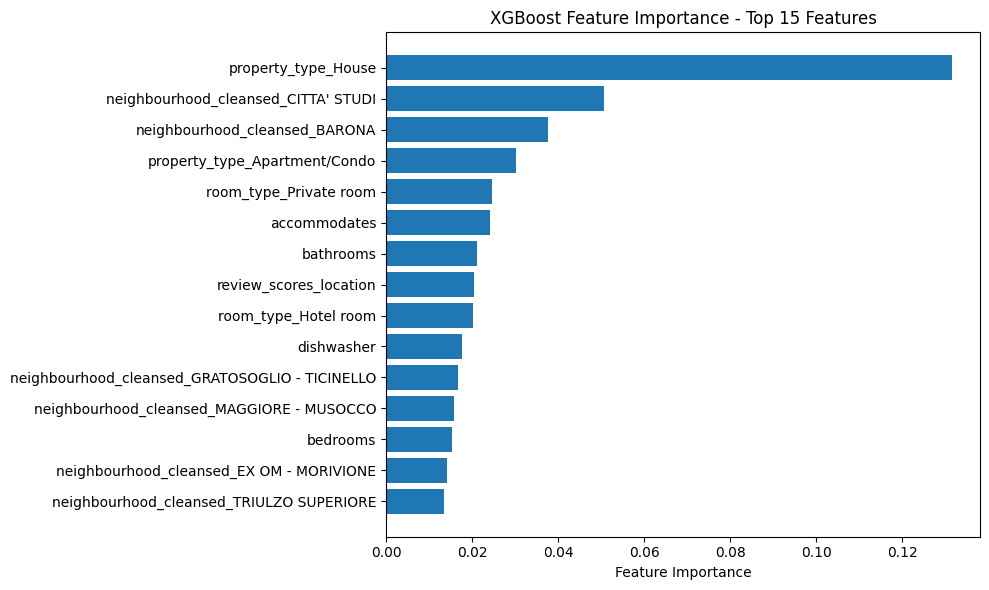


SHAP ANALYSIS
Analyzing 500 predictions with SHAP TreeExplainer...
SHAP values computed: (500, 107)

SHAP Feature Importance Ranking:


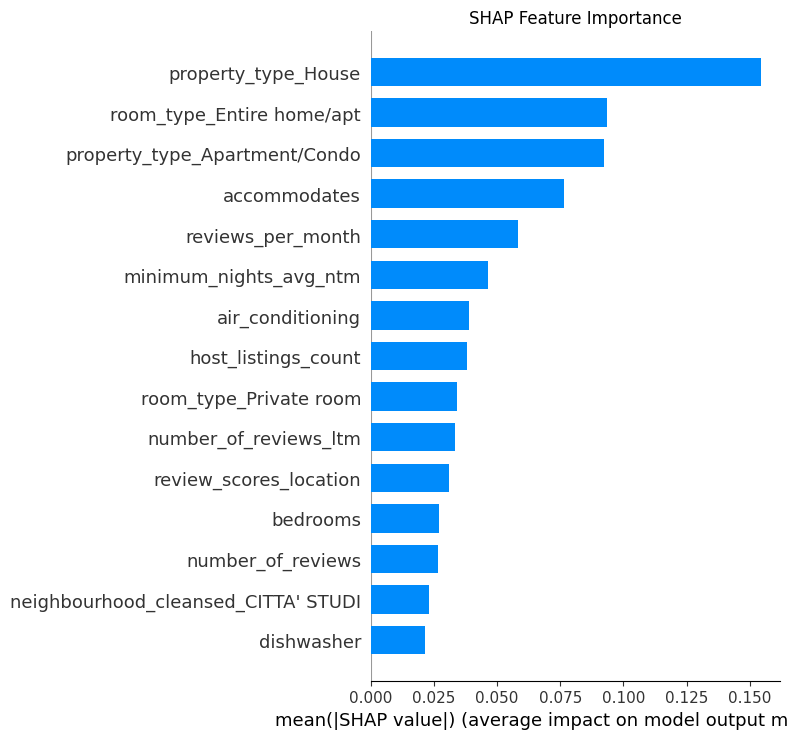


SHAP Impact Direction Analysis:


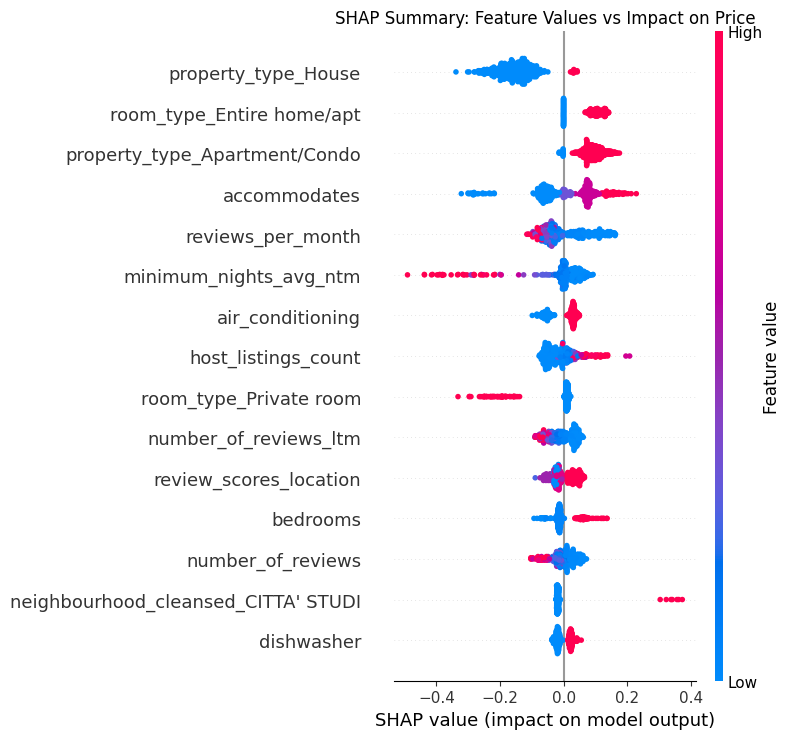


Individual Prediction Explanation:
Waterfall plot error: waterfall() got an unexpected keyword argument 'feature_names'

SHAP Feature Ranking (Top 15):
                            feature  mean_abs_shap
                property_type_House       0.154306
          room_type_Entire home/apt       0.093603
      property_type_Apartment/Condo       0.092220
                       accommodates       0.076658
                  reviews_per_month       0.058210
             minimum_nights_avg_ntm       0.046564
                   air_conditioning       0.038982
                host_listings_count       0.038092
             room_type_Private room       0.034012
              number_of_reviews_ltm       0.033422
             review_scores_location       0.030751
                           bedrooms       0.026941
                  number_of_reviews       0.026575
neighbourhood_cleansed_CITTA' STUDI       0.022920
                         dishwasher       0.021546

METHODOLOGY COMPARISON
Rank co

In [28]:
# =====================================================
# FEATURE IMPORTANCE AND SHAP ANALYSIS
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# 1. XGBOOST BUILT-IN FEATURE IMPORTANCE
print("XGBOOST FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Extract the XGBoost regressor from the pipeline
xgb_regressor = final_model.named_steps['regressor']
importance = xgb_regressor.feature_importances_

# Create feature importance DataFrame with real names
importance_df = pd.DataFrame({
    'feature': real_feature_names[:len(importance)],
    'importance': importance
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'])
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance - Top 15 Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# =====================================================
# 2. SHAP ANALYSIS
# =====================================================

print("\nSHAP ANALYSIS")
print("=" * 60)

# Prepare data for SHAP
X_test_transformed = final_model[:-1].transform(X_test)

# Sample for computational efficiency
sample_size = 500
if len(X_test_transformed) > sample_size:
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_test_transformed), sample_size, replace=False)
    X_sample = X_test_transformed[sample_indices]
else:
    X_sample = X_test_transformed
    sample_indices = np.arange(len(X_test_transformed))

print(f"Analyzing {len(X_sample)} predictions with SHAP TreeExplainer...")

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values computed: {shap_values.shape}")

# SHAP Feature Importance Bar Plot
print("\nSHAP Feature Importance Ranking:")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, 
                  feature_names=real_feature_names[:shap_values.shape[1]],
                  plot_type="bar", max_display=15, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# SHAP Summary Plot
print("\nSHAP Impact Direction Analysis:")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample,
                  feature_names=real_feature_names[:shap_values.shape[1]],
                  max_display=15, show=False)
plt.title("SHAP Summary: Feature Values vs Impact on Price")
plt.tight_layout()
plt.show()

# Individual Prediction Explanation
print("\nIndividual Prediction Explanation:")
try:
    shap.waterfall_plot(explainer.expected_value, shap_values[0], X_sample[0],
                       feature_names=real_feature_names[:shap_values.shape[1]],
                       max_display=10)
    
    # Prediction details
    actual_price = np.expm1(y_test.iloc[sample_indices[0]])
    predicted_price = np.expm1(final_model.predict(X_test.iloc[sample_indices[0]:sample_indices[0]+1])[0])
    
    print(f"Actual Price: ${actual_price:.2f}")
    print(f"Predicted Price: ${predicted_price:.2f}")
    print(f"Absolute Error: ${abs(actual_price - predicted_price):.2f}")
    
except Exception as e:
    print(f"Waterfall plot error: {e}")

# SHAP Feature Ranking
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
shap_ranking = pd.DataFrame({
    'feature': real_feature_names[:len(mean_abs_shap)],
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print("\nSHAP Feature Ranking (Top 15):")
print(shap_ranking.head(15).to_string(index=False))

# =====================================================
# 3. METHODOLOGY COMPARISON
# =====================================================

print("\nMETHODOLOGY COMPARISON")
print("=" * 60)

# Merge importance measures
comparison = pd.merge(
    importance_df.head(15)[['feature', 'importance']].rename(columns={'importance': 'XGBoost_Importance'}),
    shap_ranking.head(15)[['feature', 'mean_abs_shap']].rename(columns={'mean_abs_shap': 'SHAP_Importance'}),
    on='feature',
    how='outer'
).fillna(0)

# Calculate rank correlation
xgb_ranks = comparison['XGBoost_Importance'].rank(ascending=False)
shap_ranks = comparison['SHAP_Importance'].rank(ascending=False)
correlation = xgb_ranks.corr(shap_ranks)

print(f"Rank correlation between XGBoost and SHAP importance: {correlation:.3f}")

if correlation > 0.7:
    print("Assessment: Strong agreement between methods")
elif correlation > 0.5:
    print("Assessment: Moderate agreement between methods")
else:
    print("Assessment: Low agreement - requires further investigation")

# =====================================================
# 4. BUSINESS ANALYSIS
# =====================================================

print("\nBUSINESS ANALYSIS")
print("=" * 60)

# Categorize top features
top_5_features = importance_df.head(5)

print("Top 5 Pricing Drivers:")
for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
    feature_name = row['feature']
    importance_val = row['importance']
    
    # Determine category
    if 'property_type' in feature_name.lower():
        category = "Property Type"
    elif 'neighbourhood' in feature_name.lower():
        category = "Location"
    elif any(word in feature_name.lower() for word in ['accommodates', 'bedrooms', 'bathrooms', 'beds']):
        category = "Size/Capacity"
    elif 'review' in feature_name.lower() or 'rating' in feature_name.lower():
        category = "Reviews"
    elif 'room_type' in feature_name.lower():
        category = "Room Type"
    else:
        category = "Amenities/Other"
    
    print(f"{i}. {category}: {feature_name} (Importance: {importance_val:.4f})")

print("\nKey Findings:")
print("1. Property type is the primary pricing differentiator")
print("2. Location creates significant value premiums")  
print("3. Property size directly correlates with pricing power")
print("4. Review quality affects competitive positioning")

print("\nRecommendations:")
print("1. Optimize property type classification and marketing")
print("2. Leverage location advantages in pricing strategy")
print("3. Consider capacity optimization where feasible")
print("4. Maintain review quality standards")

print(f"\nModel Performance Summary:")
test_r2 = r2_score(y_test, final_model.predict(X_test))
print(f"R-squared: {test_r2:.4f}")
print(f"Explained variance: {test_r2*100:.1f}%")